## Importación BBDD

In [32]:
from sqlalchemy import create_engine
import pandas as pd

#Datos de conexión
usuario='EquipoB'

contraseña="E1q2u3i4p5oB"
host='212.227.90.6'
puerto=3306
nombre_base_datos='EquipB'

#Crear la URL de la conexión
url_conexion=f"mysql+mysqlconnector://{usuario}:{contraseña}@{host}:{puerto}/{nombre_base_datos}"

try:
    #Crear el engine de SQLAlchemy
    engine=create_engine(url_conexion)
    cnx=engine.connect()

    print("Conexión correcta")

except Exception as e:
    print(f"Error al conectar con SQLAlchemy: {e}")
    
#Cargar Vista_finances
query=f"SELECT * FROM vista_finances"

try:
    df_finanzas = pd.read_sql(query, cnx)
    print(f"Vista cargada correctamente.")
except Exception as e:
    print(f"Error al cargar la vista:{e}")

#Cerrar la conexión
cnx.close()

Conexión correcta
Vista cargada correctamente.


## EDA

Comprobación de los primeros registros del dataframe y la información clave de los campos

In [33]:
df_finanzas.head()

,id,age,job,marital,education,faltante,balance,housing,loan
0,1,59,admin.,married,secondary,0,2343,1,0
1,3,56,admin.,married,secondary,0,45,0,0
2,4,41,technician,married,secondary,0,1270,1,0
3,5,55,services,married,secondary,0,2476,1,0
4,6,54,admin.,married,tertiary,0,184,0,0


In [34]:
df_finanzas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         11162 non-null  int64 
 1   age        11162 non-null  int64 
 2   job        11162 non-null  object
 3   marital    11162 non-null  object
 4   education  11162 non-null  object
 5   faltante   11162 non-null  int64 
 6   balance    11162 non-null  int64 
 7   housing    11162 non-null  int64 
 8   loan       11162 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 785.0+ KB


In [35]:
df_finanzas.describe()

,id,age,faltante,balance,housing,loan
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,5582.499910,41.232754,0.015051,1528.538524,0.473123,0.130801
std,3222.336342,11.910672,0.121761,3225.413326,0.499299,0.337198
min,1.000000,18.000000,0.000000,-6847.000000,0.000000,0.000000
25%,2792.250000,32.000000,0.000000,122.000000,0.000000,0.000000
50%,5582.500000,39.000000,0.000000,550.000000,0.000000,0.000000
75%,8372.750000,49.000000,0.000000,1708.000000,1.000000,0.000000
max,11163.000000,95.000000,1.000000,81204.000000,1.000000,1.000000


*No hay valores nulos, el tipo de dato corresponde a las variables; la variable balance presenta mucha dispersión*

**Desafío 1: ¿En qué medida los clientes con saldos más bajos están en más riesgo de incumplimiento de crédito, y cómo ajustar nuestras políticas de crédito para mitigar este riesgo?**

Representación gráfica de las variables más relevantes para el desafío 1: columnas 'faltante' (originalmente *default*) y 'balance'

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# plt.style.use('ggplot')

*NOTA: para mejorar la comprensión de los gráficos, reemplazo el nombre de la columna 'faltante' por 'incumplimiento_credito' y los valores booleanos por 'si' y 'no'*

In [37]:
df_finanzas['faltante']= df_finanzas['faltante'].replace({0:"no", 1:"si"})

df_finanzas = df_finanzas.rename(columns = {'faltante':'incumplimiento_credito'})

In [38]:
df_finanzas

,id,age,job,marital,education,incumplimiento_credito,balance,housing,loan
0,1,59,admin.,married,secondary,no,2343,1,0
1,3,56,admin.,married,secondary,no,45,0,0
2,4,41,technician,married,secondary,no,1270,1,0
3,5,55,services,married,secondary,no,2476,1,0
4,6,54,admin.,married,tertiary,no,184,0,0
...,...,...,...,...,...,...,...,...,...
11157,11159,33,blue-collar,single,primary,no,1,1,0
11158,11160,39,services,married,secondary,no,733,0,0
11159,11161,32,technician,single,secondary,no,29,0,0
11160,11162,43,technician,married,secondary,no,0,0,1


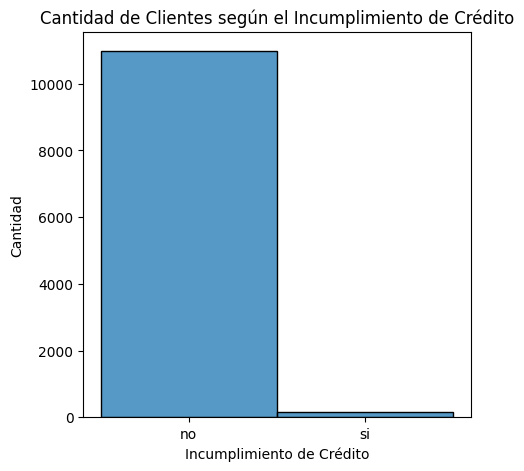

In [39]:
plt.figure(figsize=(5, 5))

sns.histplot(data=df_finanzas, x="incumplimiento_credito")

plt.title("Cantidad de Clientes según el Incumplimiento de Crédito")
plt.xlabel("Incumplimiento de Crédito")
plt.ylabel("Cantidad")
plt.show()

In [40]:
df_finanzas['incumplimiento_credito'].value_counts()

incumplimiento_credito
no    10994
si      168
Name: count, dtype: int64

Hay muy poca proporción de clientes que incumplieron con su crédito frente al resto, concretamente 168 vs. 10994 clientes. 

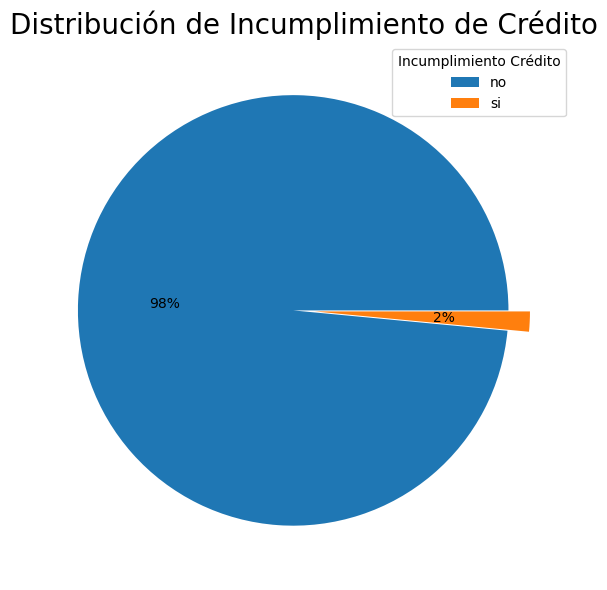

In [41]:
recuento_default = df_finanzas['incumplimiento_credito'].value_counts().reset_index(name="cantidad")

explode = (0.05, 0.05)  

plt.figure(figsize=(6,6))
plt.pie(recuento_default["cantidad"], autopct='%1.0f%%',explode=explode)
plt.title("Distribución de Incumplimiento de Crédito", fontsize=20)

plt.legend(title="Incumplimiento Crédito", labels=recuento_default["incumplimiento_credito"])
plt.tight_layout()
plt.show()

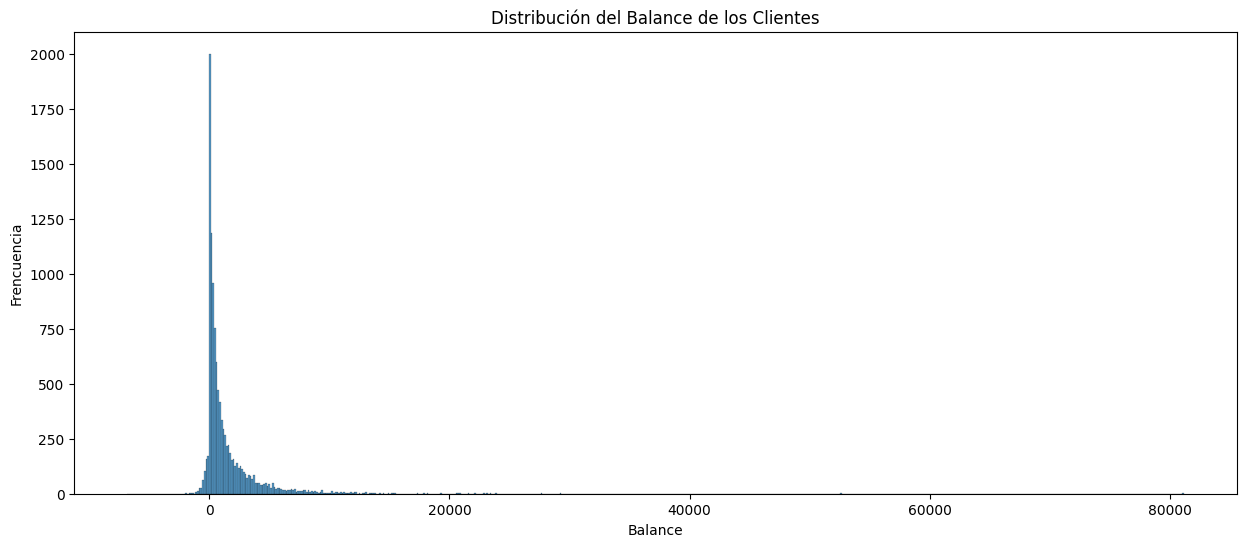

In [42]:
plt.figure(figsize=(15, 6))

sns.histplot(data=df_finanzas, x="balance")

plt.title("Distribución del Balance de los Clientes")
plt.xlabel("Balance")
plt.ylabel("Frencuencia")
plt.show()

In [43]:
con_incumplimiento_credito = df_finanzas.query('incumplimiento_credito == "si"')

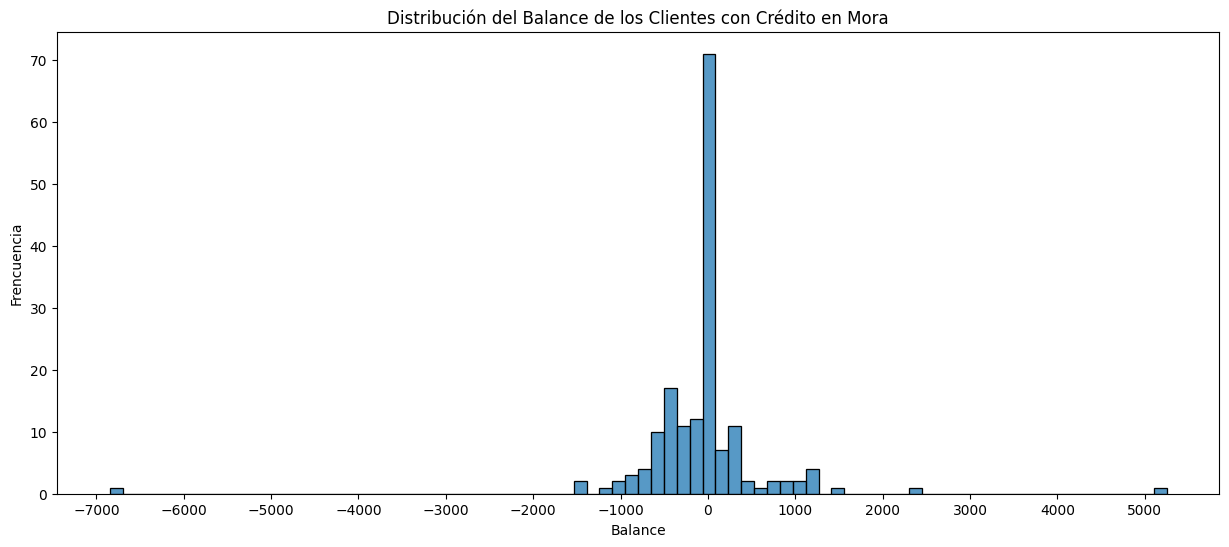

In [44]:
plt.figure(figsize=(15, 6))

sns.histplot(data=con_incumplimiento_credito, x='balance')

plt.xticks(np.arange(-7000,6000,1000))

plt.title("Distribución del Balance de los Clientes con Crédito en Mora")
plt.xlabel("Balance")
plt.ylabel("Frencuencia")
plt.show()

A continuación, vamos a confirmar la tendencia central y la dispersión del balance de los clientes, e identificar los posibles valores atípicos

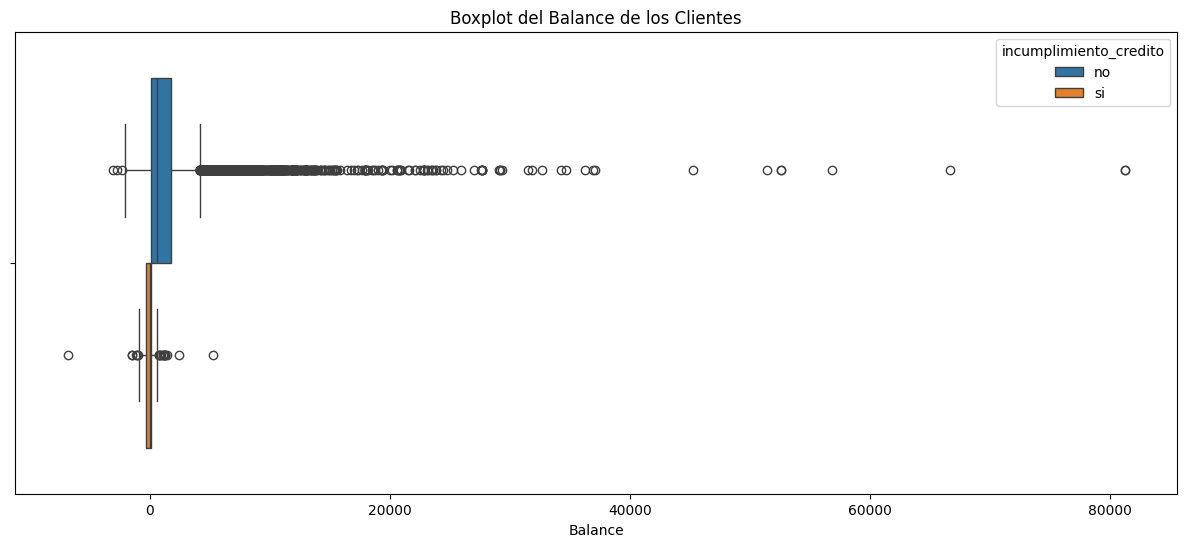

In [45]:
plt.figure(figsize=(15, 6))

sns.boxplot(data=df_finanzas, x = "balance", hue = "incumplimiento_credito")

plt.title("Boxplot del Balance de los Clientes")
plt.xlabel("Balance")

plt.show()

In [46]:
df_finanzas['balance'].value_counts()

balance
 0       774
 1        39
 3        35
 2        34
 4        29
        ... 
 5517      1
 8332      1
 4859      1
-267       1
-134       1
Name: count, Length: 3805, dtype: int64

El balance de los clientes que no incumplieron con el crédito presenta muchos más outliers y está más disperso. En cambio, los balances de los que sí incumplieron con su crédito estan más concentrados alrededor de 0. 

*Curiosidad*: la moda del balance es 0, con los datos que tenemos en el dataset no podemos saber exactamente qué significa. Suposiciones: cuenta sin movimientos, clientes nuevos (que se impute balance de 0 por defecto), clientes sin deudas en su cuenta (si suponemos que es de crédito; esto explicaría los balances negativos, pero no del todo los balances muy elevados)

## Análisis

Necesitamos averiguar si hay alguna asociación entre el balance bajo y el incumplimiento de crédito, y en qué medida. 

Para ello, consideramos que una de las opciones es agrupar los clientes en función del balance presente en sus cuentas y, así, poder calcular el % de incumplimiento de cada grupo y ver si existe alguna tendencia. 

Criterio de clasificación utilizado: cuartiles

In [47]:
df_finanzas['balance'].describe()

count    11162.000000
mean      1528.538524
std       3225.413326
min      -6847.000000
25%        122.000000
50%        550.000000
75%       1708.000000
max      81204.000000
Name: balance, dtype: float64

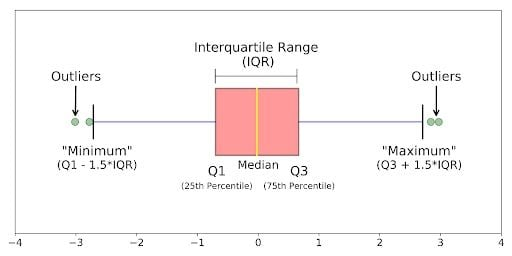

In [48]:
def cuartiles(df):
    #calcular cuartiles
    Q1 = df.quantile(0.25)
    Q2 = df.quantile(0.50)
    Q3 = df.quantile(0.75)

    #calcular IQR (rango intercuartílico)
    IQR = Q3 - Q1

    #calcular límite outliers
    min_Q = Q1 - 1.5*IQR
    max_Q = Q3 + 1.5*IQR
    
    return Q1, Q2, Q3, min_Q, max_Q

Q1, Q2, Q3, min_Q, max_Q = cuartiles(df_finanzas['balance'])

print(f"Minimum: {min_Q}\n"
      f"Q1: {Q1}\n"
      f"Q2: {Q2}\n"
      f"Q3: {Q3}\n"
      f"Maximum: {max_Q}")

Minimum: -2257.0
Q1: 122.0
Q2: 550.0
Q3: 1708.0
Maximum: 4087.0


Classificación de los clientes según su balance; hemos incluído categorías específicas para tratar con los outliers negativos (categoría muy bajo) y positivos (categoría muy alto) por separado.
* Muy bajo: 
    * balance < -2257
* Bajo: 
    * -2257 ≤ balance < 122
* Medio-bajo:
    * 122 ≤ balance < 550
* Medio-alto:
    * 550 ≤ balance < 1708
* Alto:
    * 1708 ≤ balance < 4087
* Muy alto:
    * balance > 4087

In [49]:
def clasificacion_clientes (balance):
    if balance < min_Q:
        return "muy bajo"
    elif balance < Q1:
        return "bajo"
    elif balance < Q2:
        return "medio-bajo"
    elif balance < Q3:
        return "medio-alto"
    elif balance < max_Q:
        return "alto"
    else:
        return "muy alto"
    
df_finanzas["descripcion_balance"] = df_finanzas["balance"].apply(clasificacion_clientes)

In [50]:
df_finanzas

,id,age,job,marital,education,incumplimiento_credito,balance,housing,loan,descripcion_balance
0,1,59,admin.,married,secondary,no,2343,1,0,alto
1,3,56,admin.,married,secondary,no,45,0,0,bajo
2,4,41,technician,married,secondary,no,1270,1,0,medio-alto
3,5,55,services,married,secondary,no,2476,1,0,alto
4,6,54,admin.,married,tertiary,no,184,0,0,medio-bajo
...,...,...,...,...,...,...,...,...,...,...
11157,11159,33,blue-collar,single,primary,no,1,1,0,bajo
11158,11160,39,services,married,secondary,no,733,0,0,medio-alto
11159,11161,32,technician,single,secondary,no,29,0,0,bajo
11160,11162,43,technician,married,secondary,no,0,0,1,bajo


In [51]:
categorias_balance = df_finanzas["descripcion_balance"].value_counts().reset_index(name="cantidad")

Text(0, 0.5, 'Cantidad')

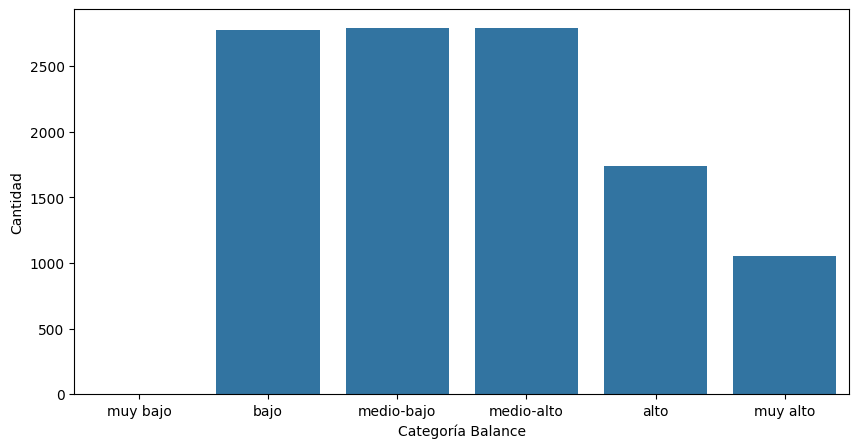

In [52]:
order = ['muy bajo', 'bajo', 'medio-bajo', 'medio-alto', 'alto', 'muy alto']

plt.figure(figsize=(10,5))
sns.barplot(data=categorias_balance, x="descripcion_balance", y="cantidad", order=order)

plt.xlabel("Categoría Balance")
plt.ylabel("Cantidad")

Prácticamente no hay outliers negativos.

In [53]:
#crear tabla con la cantidad de incumplimientos de créditos por categoría de balance
si_incumplimiento = df_finanzas.query("incumplimiento_credito == 'si'").groupby(by="descripcion_balance").size().reset_index(name="si")
no_incumplimiento = df_finanzas.query("incumplimiento_credito == 'no'").groupby(by="descripcion_balance").size().reset_index(name="no")

balance_incumplimiento = pd.merge(no_incumplimiento, si_incumplimiento, on="descripcion_balance")

#calcular el porcentaje de incumplimiento de crédito para cada categoría
balance_incumplimiento["% incumplimiento"] = (balance_incumplimiento['si']/(balance_incumplimiento['si']+balance_incumplimiento['no']))*100

#ordenar las categorías
balance_incumplimiento['descripcion_balance'] = pd.Categorical(balance_incumplimiento['descripcion_balance'], categories=order, ordered=True)
balance_incumplimiento = balance_incumplimiento.sort_values(by='descripcion_balance').reset_index(drop=True)

balance_incumplimiento

,descripcion_balance,no,si,% incumplimiento
0,muy bajo,3,1,25.000000
1,bajo,2643,136,4.893847
2,medio-bajo,2777,17,0.608447
3,medio-alto,2781,12,0.429646
4,alto,1739,1,0.057471
5,muy alto,1051,1,0.095057


En la tabla vemos que la categoría de balance muy bajo (outliers negativos) únicamente tiene 4 muestras, por lo que el porcentaje de incumplimiento es muy elevado en comparación a las otras. Hay que vigilar las conclusioens que sacamos de aquí.

Teniendo en cuenta esto, intentaremos aplicar métodos matemáticos y/o estadísticos para intentar mitigar el efecto del desbalance de la muestra y comparar los resultados. 

Text(0, 0.5, 'Porcentaje de Incumplimiento')

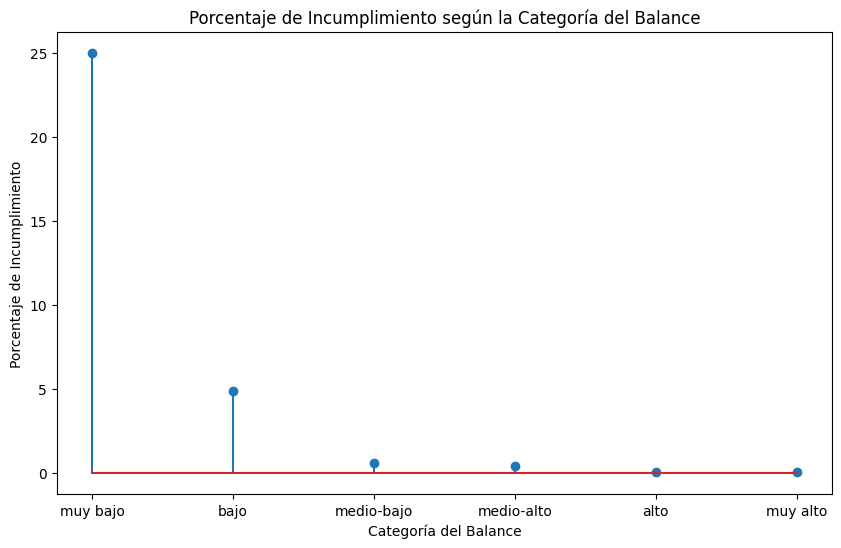

In [54]:
plt.figure(figsize=(10,6))

plt.stem(balance_incumplimiento['descripcion_balance'],balance_incumplimiento['% incumplimiento'])

plt.title("Porcentaje de Incumplimiento según la Categoría del Balance")
plt.xlabel("Categoría del Balance")
plt.ylabel("Porcentaje de Incumplimiento")

¿Y cómo varian los porcentajes si categorizamos los outliers negativos en la categoría de balance bajo y los outliers positivos en la categoría de balance alto?

In [55]:
df_finanzas_2 = df_finanzas.copy()

df_finanzas_2['descripcion_balance'] = df_finanzas_2['descripcion_balance'].replace({"muy bajo":"bajo", "muy alto": "alto"})

balance_incumplimiento_2 = pd.merge(df_finanzas_2.query("incumplimiento_credito == 'no'").groupby(by="descripcion_balance").size().reset_index(name="no"), 
                                    df_finanzas_2.query("incumplimiento_credito == 'si'").groupby(by="descripcion_balance").size().reset_index(name="si"), 
                                    on="descripcion_balance")

#calcular el porcentaje de incumplimiento de crédito para cada categoría
balance_incumplimiento_2["% incumplimiento"] = (balance_incumplimiento_2['si']/
                                                (balance_incumplimiento_2['si']+balance_incumplimiento_2['no']))*100

#ordenar las categorías
balance_incumplimiento_2['descripcion_balance'] = pd.Categorical(balance_incumplimiento_2['descripcion_balance'], 
                                                                            categories=['bajo','medio-bajo','medio-alto','alto'], 
                                                                            ordered=True)

balance_incumplimiento_2 = balance_incumplimiento_2.sort_values(by='descripcion_balance').reset_index(drop=True)

balance_incumplimiento_2

,descripcion_balance,no,si,% incumplimiento
0,bajo,2646,137,4.922745
1,medio-bajo,2777,17,0.608447
2,medio-alto,2781,12,0.429646
3,alto,2790,2,0.071633


Text(0, 0.5, 'Porcentaje de Incumplimiento')

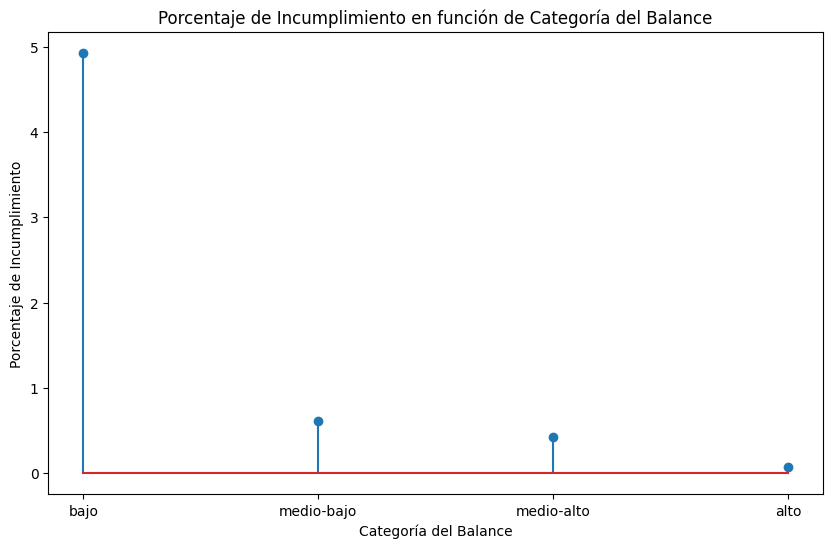

In [56]:
plt.figure(figsize=(10,6))

plt.stem(balance_incumplimiento_2['descripcion_balance'],balance_incumplimiento_2['% incumplimiento'])

plt.title("Porcentaje de Incumplimiento en función de Categoría del Balance")
plt.xlabel("Categoría del Balance")
plt.ylabel("Porcentaje de Incumplimiento")

In [57]:
diferencia_incumplimiento = pd.merge(balance_incumplimiento,
                                     balance_incumplimiento_2,
                                     on='descripcion_balance')

diferencia_incumplimiento = diferencia_incumplimiento[['descripcion_balance', '% incumplimiento_x', '% incumplimiento_y']]
diferencia_incumplimiento['diferencia'] = diferencia_incumplimiento['% incumplimiento_y'] - diferencia_incumplimiento['% incumplimiento_x']

diferencia_incumplimiento

,descripcion_balance,% incumplimiento_x,% incumplimiento_y,diferencia
0,bajo,4.893847,4.922745,0.028899
1,medio-bajo,0.608447,0.608447,0.000000
2,medio-alto,0.429646,0.429646,0.000000
3,alto,0.057471,0.071633,0.014162


Text(0.5, 1.0, 'Diferencia de % Incumplimiento')

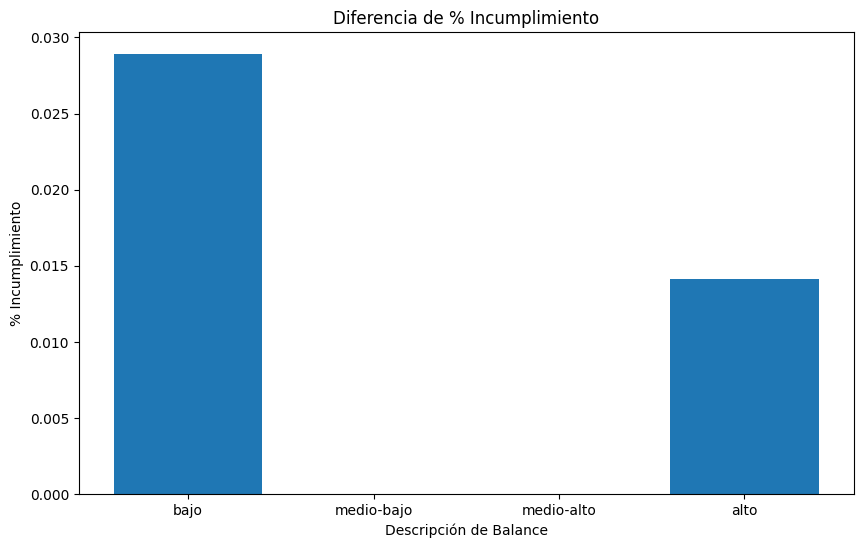

In [58]:
plt.figure(figsize=(10, 6))

plt.bar(diferencia_incumplimiento['descripcion_balance'], diferencia_incumplimiento['diferencia'])

plt.xlabel('Descripción de Balance')
plt.ylabel('% Incumplimiento')
plt.title('Diferencia de % Incumplimiento')

Tanto si separamos los datos en 6 categorías (aislando los outliers en una categoría separada), como si los separamos en 4 (categorizando los outliers a la más cercana), las diferencias en los porcentajes de incumplimiento son mínimas (como mucho 0.03%).